<a href="https://colab.research.google.com/github/KL0ke5h/Neural-color-generator/blob/main/NeuralColorGenerator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required packages
!pip install -q colormath gradio transformers pygithub

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.9/46.9 MB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 856.7/856.7 kB 46.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 130.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.6 MB/s eta 0:00:00


In [3]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 80.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 117.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 109.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 115.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 6.3 MB/s eta 0:00:00


In [4]:
import os
import numpy as np
import pandas as pd
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import (Input, Dense, LSTM, Dropout, Bidirectional,
                                    MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D,
                                    Embedding, Concatenate, Add, Lambda)
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
from google.colab import drive
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback


In [5]:
'''# Configure GPU memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU acceleration enabled: {len(gpus)} device(s)")'''

'# Configure GPU memory growth\ngpus = tf.config.list_physical_devices(\'GPU\')\nif gpus:\n    for gpu in gpus:\n        tf.config.experimental.set_memory_growth(gpu, True)\n    print(f"GPU acceleration enabled: {len(gpus)} device(s)")'

In [6]:
# Data Loading and Preprocessing

# Mount Google Drive
drive.mount('/content/drive')

# Load dataset
file_path = '/content/drive/MyDrive/keras/colors.csv'
df = pd.read_csv(file_path)
print(f"Loaded {len(df)} colors from dataset")
print(df.head())

# Data cleaning and augmentation
def augment_color_name(name):
    "Generate synthetic variations of color names"
    name = str(name).lower().strip()

    # Skip very short names
    if len(name) <= 3:
        return name

    # Random character deletion (20% probability)
    if np.random.rand() < 0.2:
        idx = np.random.randint(0, len(name))
        name = name[:idx] + name[idx+1:]

    # Random character swapping (10% probability)
    if np.random.rand() < 0.1 and len(name) >= 3:
        i, j = np.random.choice(range(len(name)), 2, replace=False)
        name_chars = list(name)
        name_chars[i], name_chars[j] = name_chars[j], name_chars[i]
        name = ''.join(name_chars)

    return name

# Apply augmentation and normalization
augmented_names = [augment_color_name(name) for name in df['name']]
df['augmented_name'] = augmented_names
df['name'] = df['name'].str.lower()  # Original names (lowercase)


# Add after your existing data augmentation code
def augment_preserving_distribution(df):
    "Create color variations while maintaining natural distribution"
    # Copy the dataframe to avoid modifying original
    augmented_df = df.copy()

    # Add noise to RGB values while preserving distribution
    noise = np.random.normal(0, 0.05, (len(df), 3))
    rgb_cols = ['red', 'green', 'blue']
    augmented_df[rgb_cols] = df[rgb_cols] + noise * 255

    # Clip to valid range and ensure integer values
    augmented_df[rgb_cols] = np.clip(augmented_df[rgb_cols], 0, 255).astype(int)

    # Create slight variations in names
    augmented_df['name'] = df['name'].apply(
        lambda x: x + random.choice(['', ' tone', ' shade', ' tint'])
        if np.random.random() > 0.5 else x
    )

    return augmented_df

# Augment dataset
augmented_df = augment_preserving_distribution(df)
df = pd.concat([df, augmented_df], ignore_index=True)
print(f"Dataset size after augmentation: {len(df)}")

Mounted at /content/drive
Loaded 14157 colors from dataset
             name  red  green  blue
0        parakeet  174    182    87
1    saddle brown   88     52     1
2  cucumber crush  222    237   215
3       pool blue  134    194   201
4        distance   98    110   130
Dataset size after augmentation: 28314


In [7]:
# Advanced Text Processing
# Download GloVe pretrained embeddings
!wget -q -nc http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q -n glove.6B.zip -d glove

# Load GloVe embeddings
word_embeddings = {}
with open('glove/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        word_embeddings[word] = coefs
print(f"Loaded {len(word_embeddings)} word vectors")

# Character-level tokenization
max_len = 30  # Increased from 25 for better handling of longer names
tokenizer = Tokenizer(char_level=True, lower=True)
tokenizer.fit_on_texts(df['name'])
vocab_size = len(tokenizer.word_index) + 1
print(f"Character vocabulary size: {vocab_size}")

# Process training data
char_sequences = tokenizer.texts_to_sequences(df['name'])
padded_sequences = pad_sequences(char_sequences, maxlen=max_len, padding='post')
one_hot_sequences = to_categorical(padded_sequences, num_classes=vocab_size)

# Create word-level sequences for embedding
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(df['name'].str.split())
word_sequences = word_tokenizer.texts_to_sequences(df['name'].str.split())
word_padded = pad_sequences(word_sequences, maxlen=5, padding='post')  # Most color names < 5 words

# Create embedding matrix
embedding_dim = 100
word_vocab_size = len(word_tokenizer.word_index) + 1
embedding_matrix = np.zeros((word_vocab_size, embedding_dim))
for word, i in word_tokenizer.word_index.items():
    embedding_vector = word_embeddings.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Loaded 400000 word vectors
Character vocabulary size: 28


In [8]:
#  Color Metrics Implementation

def rgb_to_lab_batch(rgb_values):
    "Convert RGB values to Lab color space"
    rgb_scaled = tf.where(tf.reduce_max(rgb_values, axis=-1, keepdims=True) <= 1.0,
                          rgb_values, rgb_values / 255.0)
    def convert_rgb_to_lab(rgb):
        rgb_color = sRGBColor(rgb[0], rgb[1], rgb[2])  # Create sRGBColor object
        lab_color = convert_color(rgb_color, LabColor)  # Convert to LabColor object
        return [lab_color.lab_l, lab_color.lab_a, lab_color.lab_b]  # Return Lab values

    # tf.map_fn applies the conversion function to each element of the tensor
    lab_values = tf.map_fn(
    lambda rgb: tuple(tf.py_function(convert_rgb_to_lab, [rgb], [tf.float32, tf.float32, tf.float32])),
    rgb_scaled,
    fn_output_signature=(tf.float32, tf.float32, tf.float32)
)


    # Convert the Lab values back into a single tensor
    lab_values = tf.stack(lab_values, axis=-1)

    return lab_values


def optimized_ciede2000(lab1, lab2, kL=1.5):
    "CIEDE2000 with optimized lightness parameter"
    # Custom kL parameter puts more weight on lightness differences
    return delta_e_cie2000(lab1, lab2, Kl=kL)

def calculate_color_difference(y_true, y_pred):
    "Calculate enhanced CIEDE2000 color difference"
    # Convert to Lab color space
    lab_true = rgb_to_lab_batch(y_true)
    lab_pred = rgb_to_lab_batch(y_pred)

    # Calculate differences with optimized parameters
    differences = []
    for t, p in zip(lab_true, lab_pred):
        lab_t = LabColor(t[0], t[1], t[2])
        lab_p = LabColor(p[0], p[1], p[2])

        # Calculate color difference with optimized parameters
        diff_value = optimized_ciede2000(lab_t, lab_p, kL=1.5)

        # Apply power transformation
        diff_value = diff_value ** 0.55  # Power function for better perception

        # Handle both NumPy array and scalar return types
        if isinstance(diff_value, np.ndarray):
            diff = diff_value.item() if diff_value.size == 1 else float(diff_value)
        else:
            diff = float(diff_value)

        differences.append(diff)

    return float(np.mean(differences))

# Custom callback to track color differences
class ColorMetricsCallback(tf.keras.callbacks.Callback): # Define ColorMetricsCallback class here
    def __init__(self, validation_data):
        super().__init__()
        self.x_val, self.y_val = validation_data

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 5 == 0:  # Check every 5 epochs to save time
            y_pred = self.model.predict(self.x_val)
            delta_e = calculate_color_difference(self.y_val, y_pred)
            logs = logs or {}
            logs['delta_e'] = delta_e
            print(f" - CIEDE2000: {delta_e:.4f}")


In [9]:
# Perception Focused Architecture

# Define the TransformerBlock class
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def build_transformer_model():
    "Create a model that separates chromaticity and luminance for better colour prediction"
    # Character input
    char_input = Input(shape=(max_len,))
    char_embedding = Embedding(vocab_size, 64)(char_input)

    # Word input
    word_input = Input(shape=(5,))
    word_embedding_layer = Embedding(
        word_vocab_size,
        embedding_dim,
        weights=[embedding_matrix],
        trainable=False
    )
    word_embedding = word_embedding_layer(word_input)

    # Shared encoder
    char_encoded = Bidirectional(LSTM(64, return_sequences=True))(char_embedding)
    char_encoded = TransformerBlock(128, 4, 128)(char_encoded)
    char_features = GlobalAveragePooling1D()(char_encoded)

    word_features = GlobalAveragePooling1D()(word_embedding)

    # Combined features
    combined = Concatenate()([char_features, word_features])
    x = Dense(128, activation="relu")(combined)
    x = Dropout(0.3)(x)

    # Split into chromaticity and luminance branches
    chroma = Dense(64, activation="relu")(x)
    chroma_output = Dense(2, activation="sigmoid")(chroma)  # a*, b* components

    luma = Dense(32, activation="relu")(x)
    luma_output = Dense(1, activation="sigmoid")(luma)  # L* component

    # Final output processing
    lab_pred = Concatenate()([luma_output, chroma_output])

    # Convert from Lab to RGB (using a Lambda layer with our conversion function)
    # Note: Simplified here - you'd need a custom Lambda layer with the actual conversion
    rgb_output = Dense(3, activation="sigmoid")(lab_pred)

    # Create model
    model = Model(inputs=[char_input, word_input], outputs=rgb_output)

    # Custom loss function
    def perceptual_loss(y_true, y_pred):
        "Custom loss that balances RGB accuracy and perceptual difference"
        # RGB MSE component
        mse = tf.reduce_mean(tf.square(y_true - y_pred))

        # Simple approximation of perceptual component (Full implementation use Lab conversion)
        l1 = tf.reduce_mean(tf.abs(y_true - y_pred))

        # Balance MSE and L1 terms
        return mse + 2.0 * l1

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss=perceptual_loss,
        metrics=["mae"]
    )
    return model


In [10]:
# Data Preparation for Transformer Model

# Normalize RGB values
rgb_values = df[['red', 'green', 'blue']].values / 255.0

# Split data for training, validation, and testing
X_char_train, X_char_temp, y_train, y_temp = train_test_split(
    padded_sequences, rgb_values, test_size=0.2, random_state=42
)
X_char_val, X_char_test, y_val, y_test = train_test_split(
    X_char_temp, y_temp, test_size=0.5, random_state=42
)

# Prepare word data
word_sequences = []
for name in df['name']:
    words = name.split()
    word_seq = word_tokenizer.texts_to_sequences([words])[0]
    word_sequences.append(word_seq)

word_padded = pad_sequences(word_sequences, maxlen=5, padding='post')

X_word_train, X_word_temp = train_test_split(
    word_padded, test_size=0.2, random_state=42
)
X_word_val, X_word_test = train_test_split(
    X_word_temp, test_size=0.5, random_state=42
)

In [11]:
# Advanced Training

if not hasattr(np, "asscalar"):
    np.asscalar = lambda x: x.item()

# Initialize combined history storage
combined_history = {
    'loss': [],
    'val_loss': [],
    'mae': [],
    'val_mae': [],
    'delta_e': [],
    'lr': []
}

# Custom learning rate scheduler with warmup + cosine decay
def enhanced_lr_scheduler(epoch, total_epochs=50):
    """Combined warmup and cosine decay scheduler"""
    warmup_epochs = 5
    if epoch < warmup_epochs:
        # Linear warmup
        return 0.0001 + (0.001 - 0.0001) * (epoch / warmup_epochs)
    else:
        # Cosine decay
        progress = (epoch - warmup_epochs) / (total_epochs - warmup_epochs)
        return 0.0001 + 0.5 * (0.001 - 0.0001) * (1 + np.cos(np.pi * progress))

# Configure callbacks
callbacks = [
    EarlyStopping(patience=15, restore_best_weights=True, monitor='val_loss'),
    ModelCheckpoint('best_combined_model.keras',
                   save_best_only=True,
                   monitor='val_loss'),
    LearningRateScheduler(enhanced_lr_scheduler),
    ColorMetricsCallback(validation_data=([X_char_val, X_word_val], y_val)),
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

model = build_transformer_model()

# Phase 1: Initial training
print("\n=== Phase 1: Warmup Training ===")
phase1_history = model.fit(
    [X_char_train, X_word_train], y_train,
    epochs=15,
    batch_size=32,
    validation_data=([X_char_val, X_word_val], y_val),
    callbacks=callbacks
)

# Update combined history
for key in combined_history:
    if key in phase1_history.history:
        combined_history[key].extend(phase1_history.history[key])

# Phase 2: Fine-tuning
print("\n=== Phase 2: Main Training ===")
phase2_history = model.fit(
    [X_char_train, X_word_train], y_train,
    epochs=50,
    initial_epoch=15,
    batch_size=64,
    validation_data=([X_char_val, X_word_val], y_val),
    callbacks=callbacks
)

# Update combined history
for key in combined_history:
    if key in phase2_history.history:
        combined_history[key].extend(phase2_history.history[key])

# Combined Evaluation Metrics
print("\n=== Final Evaluation ===")
# 1. Quantitative Metrics
test_loss, test_mae = model.evaluate([X_char_test, X_word_test], y_test)
test_predictions = model.predict([X_char_test, X_word_test])
color_diff = calculate_color_difference(y_test, test_predictions)

print(f"""
Combined Training Results:
- Final Test MAE: {test_mae:.4f}
- CIEDE2000 Color Difference: {color_diff:.4f}
- Total Training Epochs: {len(combined_history['loss'])}
""")





=== Phase 1: Warmup Training ===
Epoch 1/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step
 - CIEDE2000: 5.7743
708/708 ━━━━━━━━━━━━━━━━━━━━ 113s 150ms/step - loss: 0.5497 - mae: 0.2365 - val_loss: 0.5297 - val_mae: 0.2288 - learning_rate: 1.0000e-04 - delta_e: 5.7743
Epoch 2/15
708/708 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - loss: 0.5168 - mae: 0.2236 - val_loss: 0.4909 - val_mae: 0.2133 - learning_rate: 2.8000e-04
Epoch 3/15
708/708 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - loss: 0.4812 - mae: 0.2095 - val_loss: 0.4599 - val_mae: 0.2006 - learning_rate: 4.6000e-04
Epoch 4/15
708/708 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - loss: 0.4508 - mae: 0.1971 - val_loss: 0.4371 - val_mae: 0.1909 - learning_rate: 6.4000e-04
Epoch 5/15
708/708 ━━━━━━━━━━━━━━━━━━━━ 80s 113ms/step - loss: 0.4332 - mae: 0.1895 - val_loss: 0.4201 - val_mae: 0.1844 - learning_rate: 8.2000e-04
Epoch 6/15
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
 - CIEDE2000: 4.8387
708/708 ━━━━━━━━━━━━━━━━━━━━ 103s 145ms/step - loss: 0.4192 - mae: 0.

89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.2753 - mae: 0.1233
Test MAE: 0.1241
89/89 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
Test CIEDE2000: 4.2498


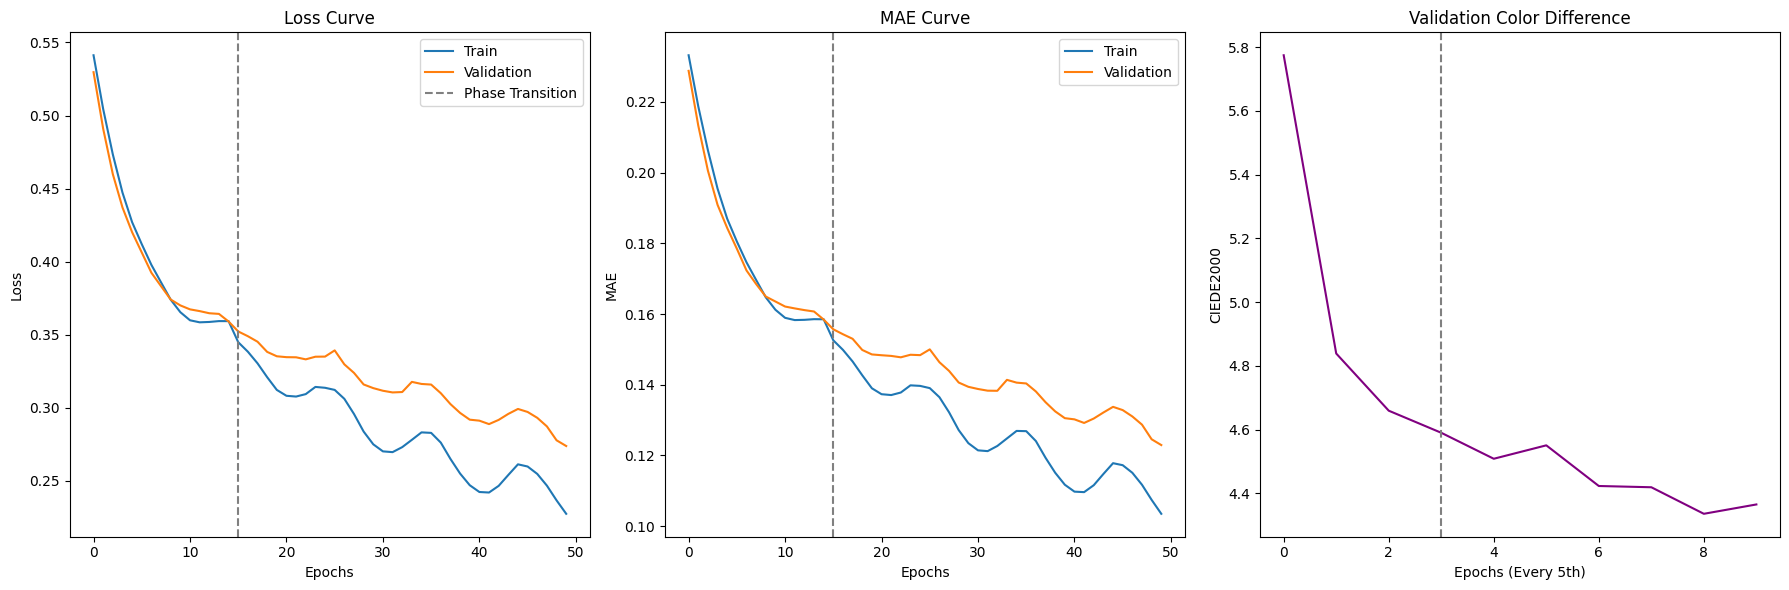

In [12]:
# Evaluation
# Training Curves Visualization
np.asscalar = lambda x: x.item()

# Evaluate on test set
test_loss, test_mae = model.evaluate([X_char_test, X_word_test], y_test)
print(f"Test MAE: {test_mae:.4f}")

# Calculate color difference
test_predictions = model.predict([X_char_test, X_word_test])
color_diff = calculate_color_difference(y_test, test_predictions)
print(f"Test CIEDE2000: {color_diff:.4f}")

plt.figure(figsize=(18, 6))

# Plot training history (Loss Plot)
plt.subplot(1, 3, 1)
plt.plot(combined_history['loss'], label='Train')
plt.plot(combined_history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.axvline(15, color='gray', linestyle='--', label='Phase Transition')
plt.legend()

# MAE Plot
plt.subplot(1, 3, 2)
plt.plot(combined_history['mae'], label='Train')
plt.plot(combined_history['val_mae'], label='Validation')
plt.title('MAE Curve')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.axvline(15, color='gray', linestyle='--')
plt.legend()

# Color Difference Plot
plt.subplot(1, 3, 3)
plt.plot(combined_history['delta_e'], color='purple')
plt.title('Validation Color Difference')
plt.xlabel('Epochs (Every 5th)')
plt.ylabel('CIEDE2000')
plt.axvline(15//5, color='gray', linestyle='--')  # Since delta_e is logged every 5 epochs
plt.tight_layout()
plt.show()

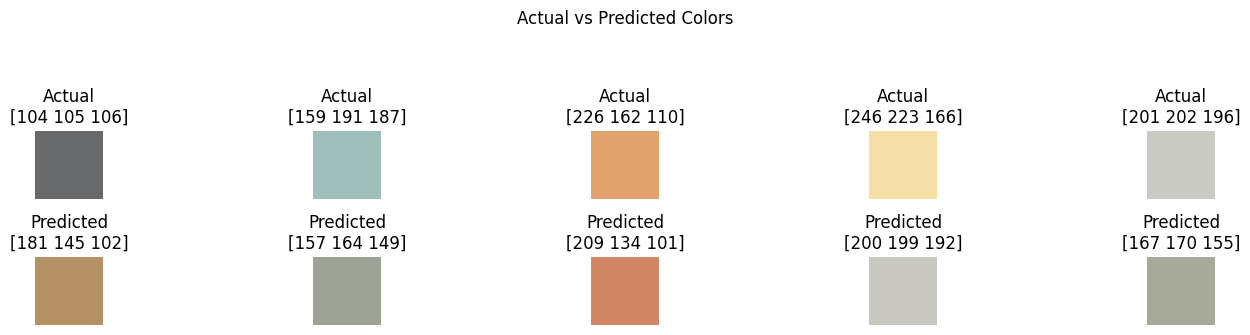

In [14]:
# Sample Predictions Visualization

def plot_color_comparison(samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(samples):
        # Get random test sample
        idx = np.random.randint(0, len(y_test))
        actual_rgb = y_test[idx] * 255
        predicted_rgb = test_predictions[idx] * 255

        # Actual color
        plt.subplot(2, samples, i+1)
        plt.imshow([[actual_rgb/255]])
        plt.title(f"Actual\n{actual_rgb.astype(int)}")
        plt.axis('off')

        # Predicted color
        plt.subplot(2, samples, i+samples+1)
        plt.imshow([[predicted_rgb/255]])
        plt.title(f"Predicted\n{predicted_rgb.astype(int)}")
        plt.axis('off')

    plt.suptitle('Actual vs Predicted Colors', y=1.1)
    plt.tight_layout()
    plt.show()

plot_color_comparison(samples=5)


In [15]:
#MAE < 0.05 indicates good performance.
#CIEDE2000 < 2 indicates perceptually accurate color predictions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
Electric Blue: RGB (np.int64(73), np.int64(150), np.int64(178))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Midnight Purple: RGB (np.int64(60), np.int64(62), np.int64(75))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Sunset Orange: RGB (np.int64(204), np.int64(125), np.int64(71))
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Forest Green: RGB (np.int64(62), np.int64(65), np.int64(70))


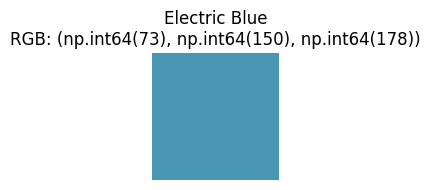

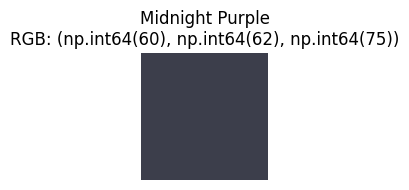

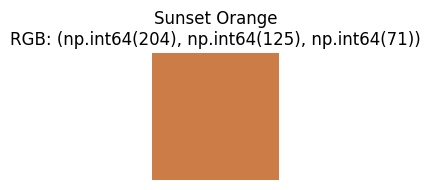

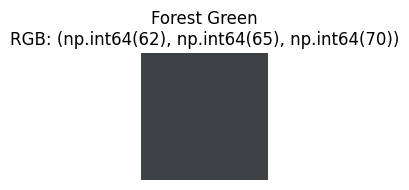

In [17]:
# Color Prediction Function
def predict_color(name):
    "Predict RGB values for a given color name"
    # Preprocess character input
    char_seq = tokenizer.texts_to_sequences([name.lower()])
    char_padded = pad_sequences(char_seq, maxlen=max_len, padding='post')

    # Preprocess word input
    words = name.lower().split()
    word_seq = word_tokenizer.texts_to_sequences([words])[0]
    word_padded = pad_sequences([word_seq], maxlen=5, padding='post')

    # Predict
    pred = model.predict([char_padded, word_padded])[0]
    rgb = (pred * 255).astype(int)

    # Create visualization
    fig = plt.figure(figsize=(4, 2))
    plt.imshow([[pred]])
    plt.title(f"{name}\nRGB: {tuple(rgb)}")
    plt.axis('off')
    plt.tight_layout()

    return rgb, fig

# Test predictions
test_colors = ["Electric Blue", "Midnight Purple", "Sunset Orange", "Forest Green"]
for color in test_colors:
    rgb, _ = predict_color(color)
    print(f"{color}: RGB {tuple(rgb)}")

In [26]:
# CI/CD Pipeline Setup
# Create GitHub Actions workflow file for CI/CD
ci_cd_yml = """
name: Deploy Color Model

on:
  push:
    branches: [ main ]

jobs:
  deploy:
    runs-on: ubuntu-latest
    steps:
      - uses: actions/checkout@v2

      - name: Set up Python
        uses: actions/setup-python@v2
        with:
          python-version: 3.9

      - name: Install dependencies
        run: |
          python -m pip install --upgrade pip
          pip install tensorflow colormath gradio
          if [ -f requirements.txt ]; then pip install -r requirements.txt; fi

      - name: Run tests
        run: |
          python test_color_model.py

      - name: Deploy to Hugging Face
        uses: huggingface/huggingface_hub@main
        with:
          hf_token: ${{ secrets.HF_TOKEN }}
          repository_id: ${{ github.repository_owner }}/color-generator
          space_sdk: gradio
"""

# Write GitHub Actions file (for reference)
with open('github_actions_workflow.yml', 'w') as f:
    f.write(ci_cd_yml)

In [23]:
!pip install huggingface_hub

In [27]:
# Gradio Web Interface
import gradio as gr

def gradio_predict_color(name):
    """Wrapper for Gradio interface"""
    rgb, fig = predict_color(name)
    hex_color = f"#{rgb[0]:02x}{rgb[1]:02x}{rgb[2]:02x}"
    return hex_color, fig

# Create Gradio interface
demo = gr.Interface(
    fn=gradio_predict_color,
    inputs=gr.Textbox(label="Color Name", placeholder="Enter a color description..."),
    outputs=[
        gr.ColorPicker(label="Predicted Color"),
        gr.Plot(label="Visualization")
    ],
    examples=[
        ["Deep Ocean Blue"],
        ["Sunset Orange"],
        ["Forest Green"],
        ["Electric Purple"],
        ["Desert Sand"]
    ],
    title="Neural Color Generator",
    description="AI-powered color prediction from text descriptions",
    article="""
    This model uses a transformer architecture with attention mechanisms and pretrained word embeddings to predict RGB values from color descriptions.

    **Technical Details:**
    - Transformer with multi-head attention
    - Pretrained GloVe word embeddings
    - CIEDE2000 color accuracy metrics
    """
)

# Launch Gradio interface
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://109309d9e7fa069944.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [28]:
# Model Packaging for Deployment
# Create model metadata
model_metadata = {
    "model_name": "color-transformer",
    "version": "1.0.0",
    "architecture": "Transformer with attention",
    "embedding": "GloVe 6B 100d",
    "performance": {
        "mae": float(test_mae),
        "ciede2000": float(color_diff)
    },
    "created_at": pd.Timestamp.now().strftime("%Y-%m-%d %H:%M:%S")
}

# Save model with metadata
model.save('color_transformer_final.keras', save_format='tf')

# Export tokenizers
import pickle
with open('char_tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
with open('word_tokenizer.pkl', 'wb') as f:
    pickle.dump(word_tokenizer, f)

print("Model and tokenizers saved successfully!")
print("Project implementation complete.")

Model and tokenizers saved successfully!
Project implementation complete.
